In [1]:
import numpy as np
from matplotlib import pyplot as plt

from os import listdir
from os.path import join
from scipy.io import wavfile

import sys

import librosa
import librosa.display

import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from keras.optimizers import Adam


from sklearn.model_selection import train_test_split



In [2]:
def trim_silence(audio, n_noise_samples=1000, noise_factor=1.0, mean_filter_size=100):
    """ Removes the silence at the beginning and end of the passed audio data
    Fits noise based on the last n_noise_samples samples in the period
    Finds where the mean-filtered magnitude > noise
    :param audio: numpy array of audio
    :return: a trimmed numpy array
    """
    start = 0
    end = len(audio)-1

    mag = abs(audio)

    noise_sample_period = mag[end-n_noise_samples:end]
    noise_threshold = noise_sample_period.max()*noise_factor

    mag_mean = np.convolve(mag, [1/float(mean_filter_size)]*mean_filter_size, 'same')

    # find onset
    for idx, point in enumerate(mag_mean):
        if point > noise_threshold:
            start = idx
            break

    # Reverse the array for trimming the end
    for idx, point in enumerate(mag_mean[::-1]):
        if point > noise_threshold:
            end = len(audio) - idx
            break

    return audio[start:end]

In [3]:
def pad_trunc(aud, max_ms):
    sig, sr = aud
    num_rows, sig_len = sig.shape
    max_len = sr//1000 * max_ms

    if (sig_len > max_len):
      # Truncate the signal to the given length
      sig = sig[:,:max_len]

    elif (sig_len < max_len):
      # Length of padding to add at the beginning and end of the signal
      pad_begin_len = random.randint(0, max_len - sig_len)
      pad_end_len = max_len - sig_len - pad_begin_len

      # Pad with 0s
      pad_begin = torch.zeros((num_rows, pad_begin_len))
      pad_end = torch.zeros((num_rows, pad_end_len))

      sig = torch.cat((pad_begin, sig, pad_end), 1)
      
    return (sig, sr)

In [4]:
def get_spectrogram(waveform):
  # Padding for files with less than 16000 samples
  zero_padding = tf.zeros([max_size] - tf.shape(waveform), dtype=tf.float32)

  # Concatenate audio with padding so that all audio clips will be of the 
  # same length
  waveform = tf.cast(waveform, tf.float32)
  equal_length = tf.concat([waveform, zero_padding], 0)
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)

  spectrogram = tf.abs(spectrogram)

  return spectrogram

In [5]:
def plot_spectrogram(spectrogram, ax):
  # Convert to frequencies to log scale and transpose so that the time is
  # represented in the x-axis (columns).
  log_spec = np.log(spectrogram.T)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)


In [6]:
files = 'recordings/'
ds_files = listdir(files)

X = []
y = []

s = []

for file in ds_files:
    label = int(file.split("_")[0])
    rate, data = wavfile.read(join(files, file))
    
    trimmed_data = trim_silence(data.astype(np.float16))
    X.append(trimmed_data)
    y.append(label)
    
    s.append(trimmed_data.shape[0])
    

max_size = np.max(s)

print(max_size)
# pad
X = [ np.pad(x, (0, max_size - x.shape[0])) for x in X ]




7998


In [7]:
train_ratio = 0.60
validation_ratio = 0.20
test_ratio = 0.20

# train is now 60% of the entire data set
# the _junk suffix means that we drop that variable completely
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio)

# test is now 20% of the initial data set
# validation is now 20% of the initial data set
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio)) 

print(len(x_train), len(x_val), len(x_test))

1800 600 600


[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

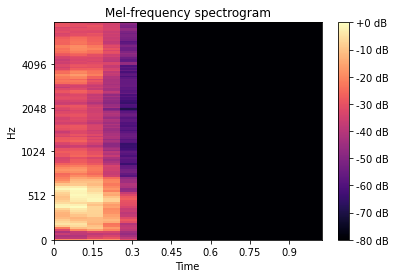

In [8]:
#librosa.feature.mfcc(y_cut, n_fft=n_fft, hop_length=512,n_mfcc=128)

#spec = librosa.stft(X[1500])
sr = 8000
S = librosa.feature.melspectrogram(X[1500], sr)

fig, ax = plt.subplots()
S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')





<ipython-input-5-9d8460ca3c5a>:4: RuntimeWarning: divide by zero encountered in log
  log_spec = np.log(spectrogram.T)
<ipython-input-5-9d8460ca3c5a>:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(X, Y, log_spec)


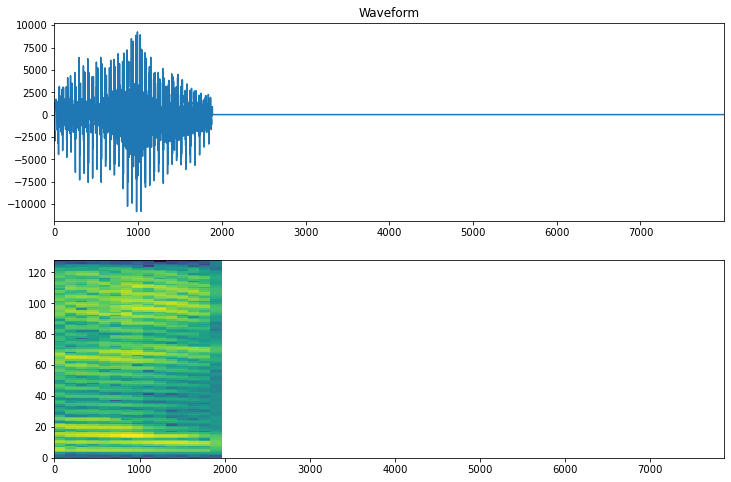

In [9]:
waveform = X[0]
spectrogram = get_spectrogram(waveform)


timescale = np.arange(waveform.shape[0])
fig, axes = plt.subplots(2, figsize=(12, 8))
axes[0].plot(timescale, waveform)
axes[0].set_title('Waveform')
axes[0].set_xlim([0, max_size])
plot_spectrogram(spectrogram.numpy(), axes[1])


In [10]:

x_train_spec = []
for x in x_train:
    x_train_spec.append(get_spectrogram(x))
    
x_train_spec = np.array(x_train_spec)


x_val_spec = []
for x in x_val:
    x_val_spec.append(get_spectrogram(x))

x_val_spec = np.array(x_val_spec)

In [11]:

x_train_mel = []
for x in x_train:
    spec = librosa.feature.melspectrogram(y=x, sr=8000)
    x_train_mel.append(librosa.power_to_db(spec, ref=np.max))
    
x_train_mel = np.array(x_train_mel)


x_val_mel = []
for x in x_val:
    spec = librosa.feature.melspectrogram(y=x, sr=8000)
    x_val_mel.append(librosa.power_to_db(spec, ref=np.max))
    
x_val_mel = np.array(x_val_mel)


In [12]:
x_train_mfcc = []
for x in x_train:
    spec = librosa.feature.mfcc(y=x, sr=8000)
    x_train_mfcc.append(spec)
    
x_train_mfcc = np.array(x_train_mfcc)


x_val_mfcc = []
for x in x_val:
    spec = librosa.feature.mfcc(y=x, sr=8000)
    x_val_mfcc.append(spec)
    
x_val_mfcc = np.array(x_val_mfcc)

In [13]:
#for spectrogram, _ in spectrogram_ds.take(1):
#  input_shape = spectrogram.shape
#print('Input shape:', input_shape)

x_train_cur = x_train_mfcc
x_val_cur = x_val_mfcc
input_shape = x_train_cur.shape
num_labels = 10

print(input_shape)

#norm_layer = preprocessing.Normalization()
#norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))

model = models.Sequential([
    layers.Input(shape=(*x_train_cur[0].shape, 1)),
    preprocessing.Resizing(32, 32), 
    #norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.Dropout(0.7),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_labels),
])

model.summary()

(1800, 20, 16)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
dropout (Dropout)            (None, 13, 13, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 10816)             0         
_________________________________________________________________
dense (Dense)                (None, 128) 

In [14]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [15]:
EPOCHS = 25
history = model.fit(
    x_train_cur, 
    np.array(y_train),
    validation_data=(x_val_cur, np.array(y_val)),  
    epochs=EPOCHS
)# 75ms/st

Epoch 1/25
57/57 [==============================] - 3s 45ms/step - loss: 8.7036 - accuracy: 0.2239 - val_loss: 0.9150 - val_accuracy: 0.6983
Epoch 2/25
57/57 [==============================] - 2s 35ms/step - loss: 0.8821 - accuracy: 0.6950 - val_loss: 0.5937 - val_accuracy: 0.7967
Epoch 3/25
57/57 [==============================] - 2s 35ms/step - loss: 0.6199 - accuracy: 0.7715 - val_loss: 0.4342 - val_accuracy: 0.8633
Epoch 4/25
57/57 [==============================] - 2s 34ms/step - loss: 0.5537 - accuracy: 0.8222 - val_loss: 0.4230 - val_accuracy: 0.8733
Epoch 5/25
57/57 [==============================] - 2s 35ms/step - loss: 0.4268 - accuracy: 0.8571 - val_loss: 0.3681 - val_accuracy: 0.8950
Epoch 6/25
57/57 [==============================] - 2s 35ms/step - loss: 0.3682 - accuracy: 0.8648 - val_loss: 0.3496 - val_accuracy: 0.9033
Epoch 7/25
57/57 [==============================] - 2s 36ms/step - loss: 0.3088 - accuracy: 0.8899 - val_loss: 0.3669 - val_accuracy: 0.8933
Epoch 8/25
57

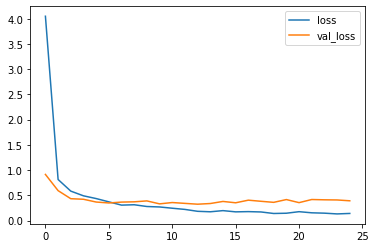

In [16]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()